In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ss_df = pd.read_csv('sample_submission.csv')

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
ss_df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [7]:
# EDA (Exploratory Data Analysis)

=== Основная информация ===
Размер датасета: (1460, 81)

=== Типы данных ===
object     43
int64      35
float64     3
dtype: int64


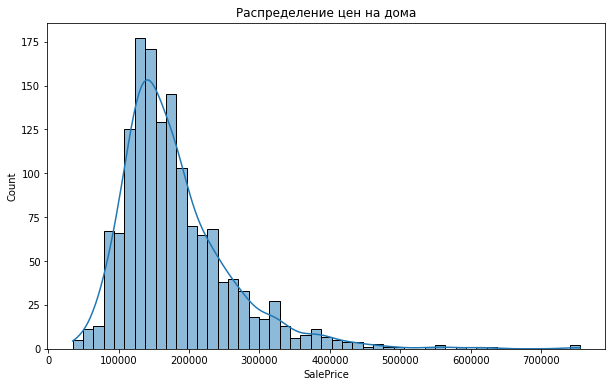

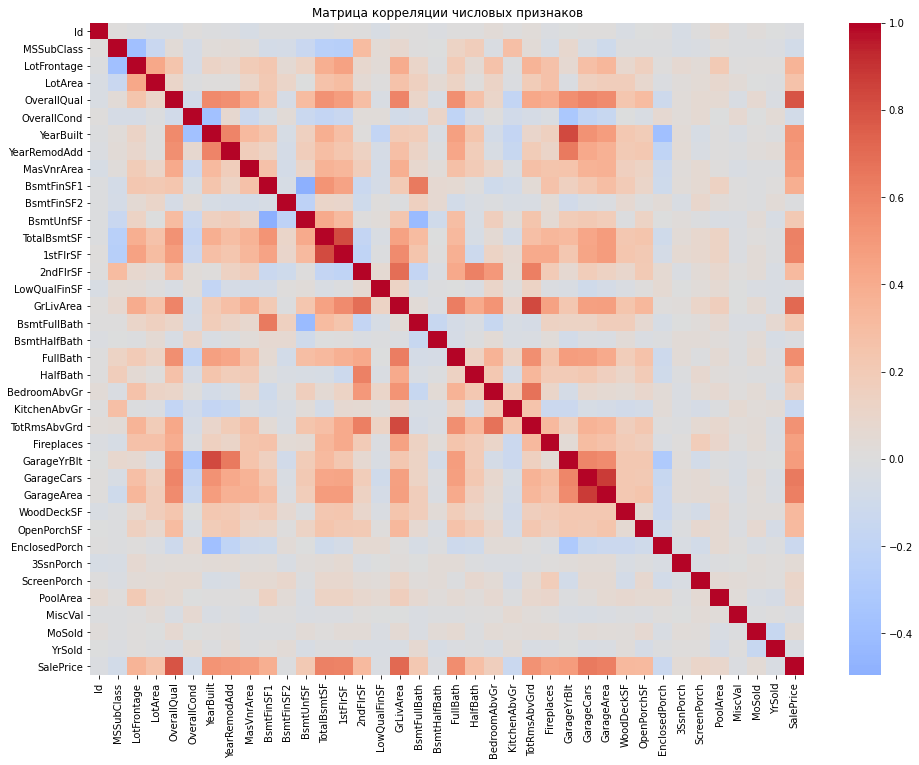

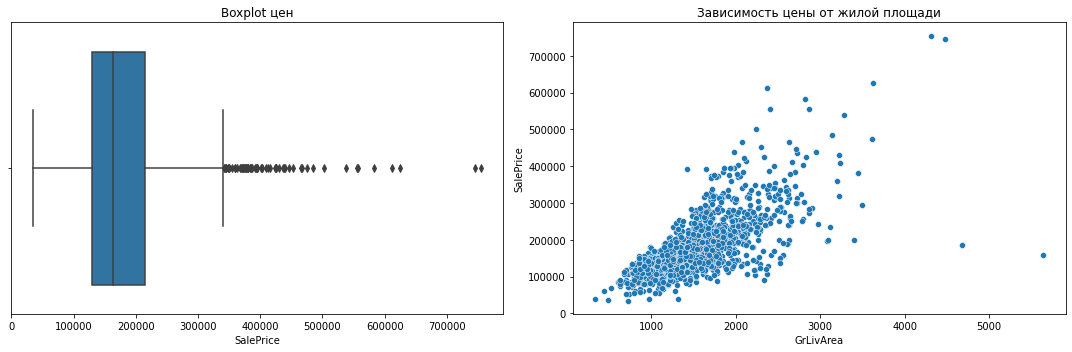

In [10]:
def perform_eda(df):
    print("=== Основная информация ===")
    print(f"Размер датасета: {df.shape}")
    print("\n=== Типы данных ===")
    print(df.dtypes.value_counts())
    
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['SalePrice'], kde=True)
    plt.title('Распределение цен на дома')
    plt.show()
    
    
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(16, 12))
    sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', center=0)
    plt.title('Матрица корреляции числовых признаков')
    plt.show()
    
   
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(x=df['SalePrice'], ax=ax[0])
    ax[0].set_title('Boxplot цен')
    sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, ax=ax[1])
    ax[1].set_title('Зависимость цены от жилой площади')
    plt.tight_layout()
    plt.show()

perform_eda(train_df)

In [ ]:
# Предобработка данных и Feature Engineering

In [33]:
def preprocess_data(df):
    # Удаление выбросов (на примере жилой площади)
    df = df[df['GrLivArea'] < 4000]
    
    # Заполнение пропусков
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
    
    # Создание новых признаков
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    
    # Логарифмирование целевой переменной для нормализации
    df['SalePriceLog'] = np.log1p(df['SalePrice'])
    
    return df

data = preprocess_data(train_df)

In [14]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [15]:
if 'SalePrice' not in numeric_cols:
    numeric_cols.append('SalePrice')

In [16]:
numeric_data = data[numeric_cols].copy()

In [17]:
numeric_data = numeric_data.fillna(0)

In [18]:
X = numeric_data.drop('SalePrice', axis=1)  # Все характеристики кроме цены
y = numeric_data['SalePrice']               # Цены домов

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
predictions = model.predict(X_test)
print("Ошибка модели:", mean_squared_error(y_test, predictions))

Ошибка модели: 739095555.2905741


In [22]:
importance = pd.DataFrame({
    'Характеристика': X.columns,
    'Важность': model.coef_  # Коэффициенты модели
}).sort_values('Важность', key=abs, ascending=False)

print("\nСамые важные характеристики:")
print(importance.head(10))


Самые важные характеристики:
   Характеристика      Важность
4     OverallQual  15471.200092
21   BedroomAbvGr -13943.619928
22   KitchenAbvGr -13619.586347
23   TotRmsAbvGrd   7004.398764
18   BsmtHalfBath  -6610.311233
5     OverallCond   4483.808978
26     GarageCars   3277.031217
20       HalfBath  -2126.035164
17   BsmtFullBath   1725.851463
24     Fireplaces    942.134483


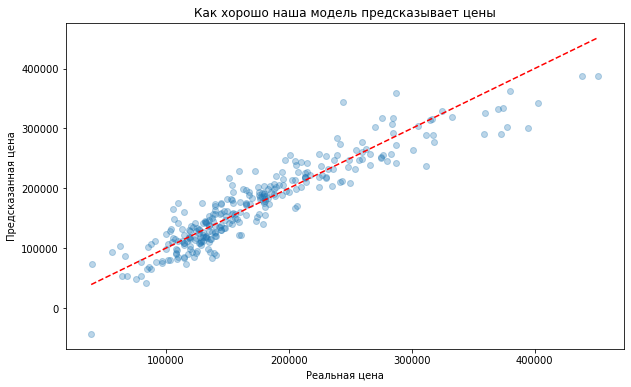

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Как хорошо наша модель предсказывает цены')
plt.show()


<Figure size 720x576 with 0 Axes>

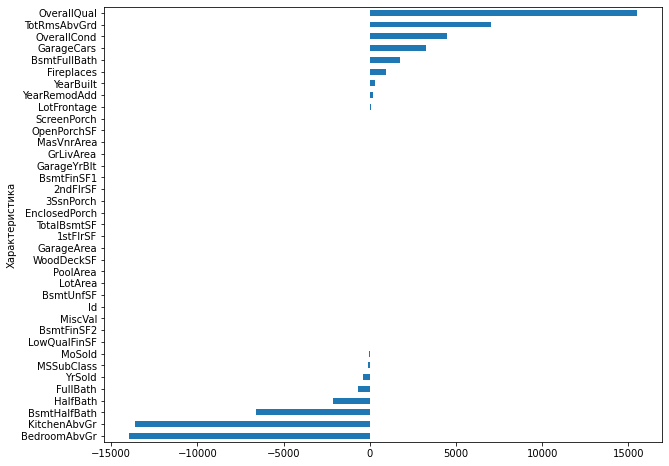

In [32]:
plt.figure(figsize=(10, 8)) 
ax = importance.sort_values('Важность').plot.barh(
    x='Характеристика', 
    y='Важность',
    figsize=(10, 8),
    legend=False
)